In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [14]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

In [17]:
start_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
start_date = np.ravel(start_date)[0]
# end_date
records = session.query(Measurement.date, func.avg(Measurement.prcp))\
          .group_by(func.strftime('%Y-%m', Measurement.date))\
          .order_by(Measurement.date.desc()).limit(12).all()
end_date = np.ravel(records[11])[0]
print(f'Start Date: {start_date} End Date: {end_date}')

Start Date: 2017-08-23 End Date: 2016-09-30


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last12 = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date.between(end_date, start_date)).all()

last12 = pd.DataFrame.from_records(last12)
last12 = last12.rename(columns={0: 'Date', 1: 'Precipitation'})
last12.set_index(last12['Date'], inplace=True)

last12.head()


,Date,Precipitation
Date,,
2016-09-30,2016-09-30,0.0
2016-10-01,2016-10-01,0.0
2016-10-02,2016-10-02,0.0
2016-10-03,2016-10-03,0.0
2016-10-04,2016-10-04,0.0


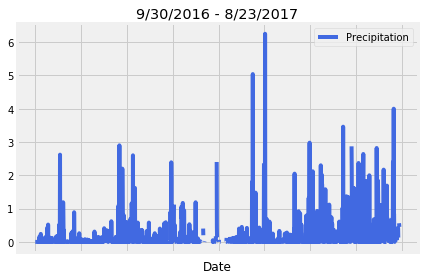

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data

last12.plot(x_compat=True, color='RoyalBlue') 
plt.xticks(rotation='45')
plt.xlabel('Date')
plt.title('9/30/2016 - 8/23/2017')
plt.tight_layout()
plt.savefig('precipitation.png')


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last12.describe()

,Precipitation
count,1801.000000
mean,0.160589
std,0.424107
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [18]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement)\
.distinct(Measurement.station)\
.group_by(Measurement.station).count()
print("There are " + str(station_count) + " stations available in this dataset.")

There are 9 stations available in this dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.tobs))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Which station has highest number of observations

most_obvs = session.query(Measurement.station)\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.tobs).desc()).first()
print(str(most_obvs) + " has the highest number of observations.")

('USC00519281',) has the highest number of observations.


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded

lowest_temp = session.query(func.min(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()

print(str(lowest_temp) + " was the lowest temperature recorded.")

[(54.0,)] was the lowest temperature recorded.


In [22]:
# Using the station id from the previous query, calculate the highest temperature recorded

highest_temp = session.query(func.max(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281').all()
            
print(str(highest_temp) + " was the highest temperature recorded.")

[(85.0,)] was the highest temperature recorded.


In [40]:
# Using the station id from the previous query, calculate the average temperature

average_temp = session.query(func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()
            
print(str(average_temp) + " is the average temperature recorded.")

[(71.66378066378067,)] is the average temperature recorded.


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station.
wslast12 = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date.between(end_date, start_date)).all()
           
wslast12 = pd.DataFrame(wslast12, columns=['Station', 'Temperature'])
wslast12.head()

,Station,Temperature
0,USC00519281,78.0
1,USC00519281,77.0
2,USC00519281,79.0
3,USC00519281,79.0
4,USC00519281,79.0


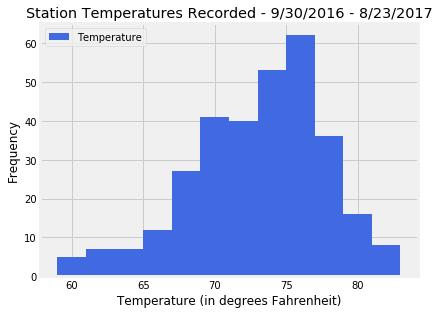

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot the results as a histogram.
wslast12.plot.hist(bins=12, color='RoyalBlue')
plt.tight_layout()
plt.title('Station Temperatures Recorded - 9/30/2016 - 8/23/2017')
plt.xlabel('Temperature (in degrees Fahrenheit)')

plt.show()
plt.savefig('station_temp.png')
